# LatamXIX Overveiw

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Surface Forms

In [2]:
with open("./data/surfaceFormsNonAccents.json", encoding='utf-8') as f:
    surfaceFormsNonAccents = json.load(f)

i = 0
for k,v in surfaceFormsNonAccents.items():
    print(f"The word '{k}' can be find as '{list(v.keys())[0]}'")
    if (i := i+1) > 10: break

The word 'y' can be find as 'i'
The word 'general' can be find as 'jeneral'
The word 'hay' can be find as 'hai'
The word 'muy' can be find as 'mui'
The word 'hoy' can be find as 'hoi'
The word 'don' can be find as 'd'
The word 'colegio' can be find as 'colejio'
The word 'soy' can be find as 'soi'
The word 'que' can be find as 'q'
The word 'cuando' can be find as 'quando'
The word 'jeroglíficos' can be find as 'geroglíficos'


## Dataset

In [3]:
# read the parquet file
cleaneddf = pd.read_parquet("./data/cleaned-latam-xix.parquet")
df = pd.read_parquet("./data/corrected-latam-xix.parquet")
df.sample(10)

,newspaper_id,text_id,title,year,city,text
9680,PF730,20230917_102143-page_0-0,Mefistofeles,1897-1905,Bogotá,Tal de hacer es víctima por e defraudado el su...
7766,PD810,Julio 1891-page_13-0,El diario de Cundinamarca,1869-18893,Bogotá,"AfC'ero auna volta-uns duchessa Veschie, noios..."
8070,PD810,Junio 1891-page_22-4,El diario de Cundinamarca,1869-18893,Bogotá,Fueron morfa del pro
4943,PD697,p17054coll26_392-page_15-1,Papel Periodico ilustrado,1881-1888,Cali,"Tan, como carros en una gran batalla ; y de ca..."
6901,PD751,9-page_1-0,El zancudo,1890-1891,Santafé de Bogotá,simbolos de su misericordia tradicionalista ; ...
6972,PD759,p17054coll26_19159-page_2-2,El democrata,1891-1892,Bogotá,"Última tarea periodística, es la despedida, la..."
2278,PD697,p17054coll26_301-page_8-1,Papel Periodico ilustrado,1881-1888,Cali,Así les dijo al ver tras los cristales Hundirs...
6291,PD747,9-page_4-3,Colombia ilustrada,1889-1892,Bogotá,José J. Gaibrois. 000 Lázaro María Pérez. (Con...
3628,PD697,p17054coll26_345-page_10-0,Papel Periodico ilustrado,1881-1888,Cali,Que dieron orden de desocupar la pieza en que ...
3008,PD697,p17054coll26_322-page_8-1,Papel Periodico ilustrado,1881-1888,Cali,"Han retirado también, arrojados quizá por algú..."


See the corections made to a random text in the dataset. Take into account that surface form were extracted BUT NOT replaced in the dataset.

In [4]:
rd_idx = random.randint(0, len(cleaneddf) - 1)

print(cleaneddf.loc[rd_idx, "text"])
print(df.loc[rd_idx, "text"])

EL FASGON. Para curarlo del susto Que Cornelio a un justo did El buen gobierno metio En la moneda a don Justo. Suspendo aqui los cantares. Para entrar en llana prosa Porque es tarea penosa" Hacer versos a inillares. I mas cuando tan prosaico Es en nuestra tierra todo :: El'rojo, el golgota, el godo ,! ..: El monigote i cl laico ..... . . ₺ DE TODO UN POCO.""' Londres cubre una area de 121 millas cuadradas. En Inglaterra i Gales hai 2,740 iglesias Congresionales: La crin de un camello pesa unas diez libras i se vende por mas de cien pesos. Un 'arbol azul de goma en:' California, tiene once pies de alto i nueve pulgadas de circunferencia. En la esposicion de Viena se -exhibe un barril de cerveza de 39 pies de alto. Puede contener 300,000 galones. La primera vez que se toco el piano en publico fue en Londres. el 16 de mayo de 1767, en el ,, teatro de Convent Garden. 1,800 buques so emplean ". anualmente en conducir"
EL FASGON. Para curarlo del susto Que Cornelio a un justo dio El buen gob

### Information

First, train a new tokenizer on the final, corrected dataset.

In [5]:
VOCAB_SIZE = 52000
TRAINING_BATCH_SIZE = 1000
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

pretrained_tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

training_corpus = (
    df.loc[i:i+TRAINING_BATCH_SIZE, "text"].astype(str) 
    for i in range(0, len(df), TRAINING_BATCH_SIZE)
)

tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus, VOCAB_SIZE)

In [6]:
example = df.loc[5, "text"]
print("BEFORE:", pretrained_tokenizer.tokenize(example)[:20])
print("AFTER:", tokenizer.tokenize(example)[:20])
tokenizer.save_pretrained("./data/tokenizer")

BEFORE: ['Bur', '##ro', 'despues', 'de', 'un', 'corto', 'pero', 'fuerte', 'reco', '##ji', '##miento', 'de', 'espíritu', ',', 'como', 'para', 'recordar', 'ideas', 'conce', '##bidas']
AFTER: ['Burro', 'despues', 'de', 'un', 'corto', 'pero', 'fuerte', 'recoj', '##imiento', 'de', 'espíritu', ',', 'como', 'para', 'recordar', 'ideas', 'concebida', '##s', 'ya', 'hace']


('./data/tokenizer\\tokenizer_config.json',
 './data/tokenizer\\special_tokens_map.json',
 './data/tokenizer\\vocab.txt',
 './data/tokenizer\\added_tokens.json',
 './data/tokenizer\\tokenizer.json')

In [7]:
# find the number of tokens in the whole df
n_tokens = sum([len(tokenizer.tokenize(text)) for text in df["text"]])
print(f"""LatamXIX dataset has:
- {n_tokens:,} tokens
- {len(df):,} rows""")

df['year'] = df['year'].str.split('-').str[0]
df['year'] = df['year'].astype(int)

Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


LatamXIX dataset has:
- 5,523,980 tokens
- 10,176 rows


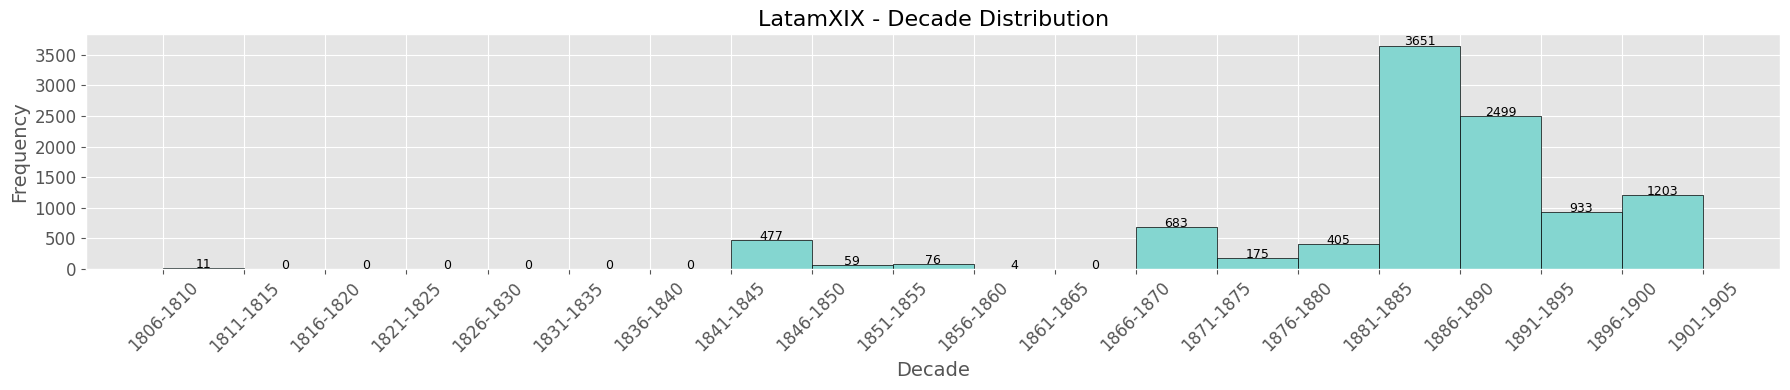

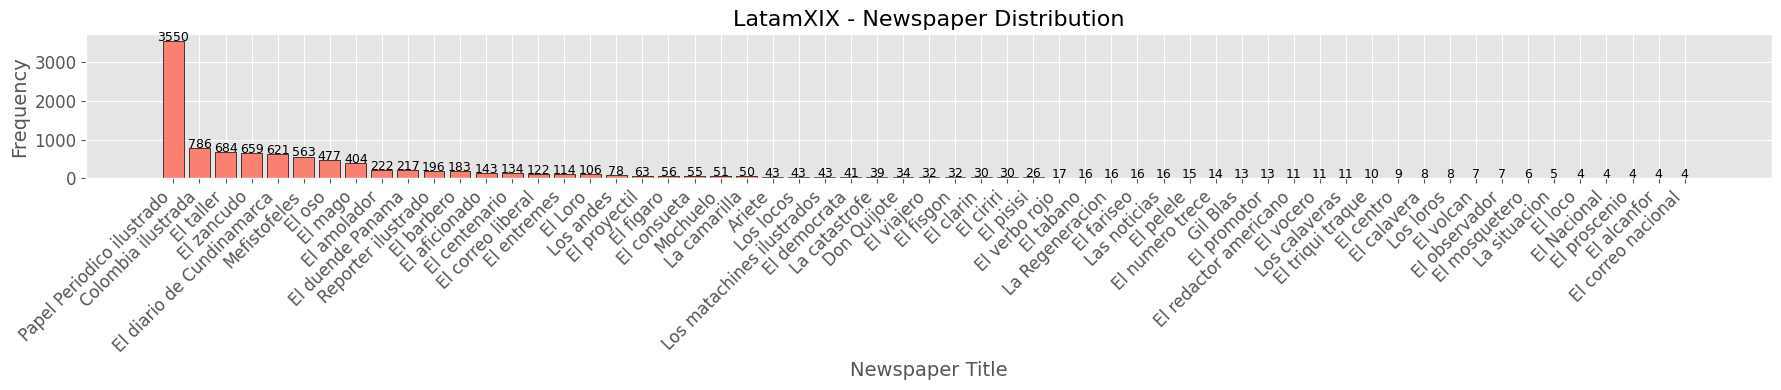

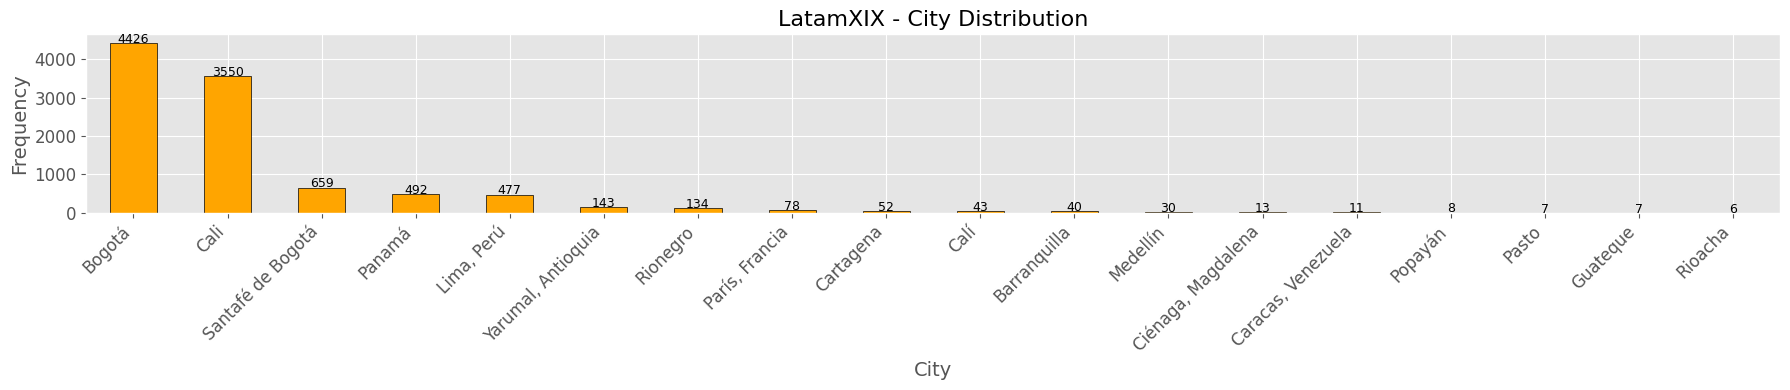

In [8]:
plt.style.use('ggplot')

# Histogram by Decade

min_year = df['year'].min()
max_year = df['year'].max()
bin_width = 5
num_bins = (max_year - min_year) // bin_width + 1
bins = np.linspace(min_year, min_year + (num_bins * bin_width), num_bins + 1)

plt.figure(figsize=(18, 4))
plt.hist(df['year'], bins=bins, edgecolor='black', align='mid', color='#84D6D0')
plt.title('LatamXIX - Decade Distribution', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=12)

plt.xticks(np.arange(min_year, max_year + bin_width, bin_width), [f'{int(year)}-{int(year+bin_width-1)}' for year in np.arange(min_year, max_year + bin_width, bin_width)], rotation=45, ha='center', fontsize=12)

for i, count in enumerate(np.histogram(df['year'], bins=bins)[0]):
    plt.text(bins[i]+2.5, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_years_histogram.png', dpi=300)
plt.show()

# Histogram by Newspaper Title

label_encoder = LabelEncoder()
df['title_label'] = label_encoder.fit_transform(df['title'])

title_counts = df['title_label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(18, 4))
plt.bar(range(len(title_counts)), title_counts.values, color='salmon', edgecolor='black')
plt.title('LatamXIX - Newspaper Distribution', fontsize=16)
plt.xlabel('Newspaper Title', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(len(title_counts)), label_encoder.inverse_transform(title_counts.index), rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(title_counts.values):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_titles_histogram.png', dpi=300)
plt.show()

# Histogram by City

plt.figure(figsize=(18, 4))
df['city'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('LatamXIX - City Distribution', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(df['city'].value_counts()):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_city_histogram.png', dpi=300)
plt.show()